In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 599ms/step - loss: 0.0478
Average validation loss: 0.65667724609375
4/4 [==============================] - 5s 611ms/step - loss: 0.0478 - val_loss: 0.6567
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 613ms/step - loss: 0.0349 - val_loss: 0.6567
Average validation loss: 0.5831767916679382
4/4 [==============================] - 7s 625ms/step - loss: 0.0349 - val_loss: 0.6199
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 589ms/step - loss: 0.0266 - val_loss: 0.6199
Average validation loss: 0.6109965443611145
4/4 [==============================] - 10s 605ms/step - loss: 0.0266 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 534ms/step - loss: 2.8760e-05
Average validation loss: 0.026998762972652912
8/8 [==============================] - 4s 544ms/step - loss: 2.8760e-05 - val_loss: 0.0270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 9s 536ms/step - loss: 2.8407e-05 - val_loss: 0.0270
Average validation loss: 0.000395725219277665
8/8 [==============================] - 9s 546ms/step - loss: 2.8407e-05 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 13s 534ms/step - loss: 2.8327e-05 - val_loss: 0.0137
Average validation loss: 0.0012290560407564044
8/8 [==============================] - 13s 543ms/s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 6s 535ms/step - loss: 8.4516e-05
Average validation loss: 0.03272092202678323
12/12 [==============================] - 7s 544ms/step - loss: 8.4516e-05 - val_loss: 0.0327
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 13s 536ms/step - loss: 8.3386e-05 - val_loss: 0.0327
Average validation loss: 0.08498642417544033
12/12 [==============================] - 13s 544ms/step - loss: 8.3386e-05 - val_loss: 0.0589
Epoch 3/10
12/12 [==============================] - 19s 531ms/step - loss: 8.1411e-05 - val_loss: 0.0589
Average validation loss: 0.031727289237702884
12/12 [==============================] - 20s 540ms/step - loss: 8.1411e-05 - val_loss: 0.0498
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weigh

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 9s 539ms/step - loss: 5.1394e-05
Average validation loss: 0.05936104689703825
16/16 [==============================] - 9s 549ms/step - loss: 5.1394e-05 - val_loss: 0.0594
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 17s 539ms/step - loss: 5.0464e-05 - val_loss: 0.0594
Average validation loss: 0.08337277679947874
16/16 [==============================] - 18s 548ms/step - loss: 5.0464e-05 - val_loss: 0.0714
Epoch 3/10
16/16 [==============================] - 26s 537ms/step - loss: 4.8646e-05 - val_loss: 0.0714
Average validation loss: 0.11180266884468892
16/16 [==============================] - 26s 545ms/step - loss: 4.8646e-05 - val_loss: 0.0848
Epoch 4/10
16/16 [==============================] - 35s 538ms/step - loss: 4.8431e-05 - val_loss: 0.0848
Average validation 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 11s 537ms/step - loss: 2.3277e-05
Average validation loss: 0.03325940761715174
20/20 [==============================] - 11s 548ms/step - loss: 2.3277e-05 - val_loss: 0.0333
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 22s 534ms/step - loss: 2.2979e-05 - val_loss: 0.0333
Average validation loss: 0.03301644567400217
20/20 [==============================] - 22s 543ms/step - loss: 2.2979e-05 - val_loss: 0.0331
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 33s 534ms/step - loss: 2.2464e-05 - val_loss: 0.0331
Average validation loss: 0.0322998333722353
20/20 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 13s 538ms/step - loss: 4.6575e-05
Average validation loss: 0.08655860150853793
24/24 [==============================] - 13s 547ms/step - loss: 4.6575e-05 - val_loss: 0.0866
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 26s 541ms/step - loss: 3.6718e-05 - val_loss: 0.0866
Average validation loss: 0.034563504780332245
24/24 [==============================] - 26s 550ms/step - loss: 3.6718e-05 - val_loss: 0.0606
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 39s 542ms/step - loss: 3.0536e-05 - val_loss: 0.0606
Average validation loss: 0.022402444543937843
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 21s 537ms/step - loss: 6.1274e-05
Average validation loss: 0.03548889085650444
40/40 [==============================] - 22s 546ms/step - loss: 6.1274e-05 - val_loss: 0.0355
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 43s 537ms/step - loss: 5.2522e-05 - val_loss: 0.0355
Average validation loss: 0.05346849262714386
40/40 [==============================] - 44s 546ms/step - loss: 5.2522e-05 - val_loss: 0.0445
Epoch 3/10
40/40 [==============================] - 65s 538ms/step - loss: 4.7845e-05 - val_loss: 0.0445
Average validation loss: 0.06277388520538807
40/40 [==============================] - 65s 546ms/step - loss: 4.7845e-05 - val_loss: 0.0506
Epoch 4/10
40/40 [==============================] - 87s 536ms/step - loss: 4.4200e-05 - val_loss: 0.0506
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 26s 539ms/step - loss: 4.2438e-05
Average validation loss: 0.028876738778005045
48/48 [==============================] - 26s 548ms/step - loss: 4.2438e-05 - val_loss: 0.0289
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 52s 540ms/step - loss: 2.9452e-05 - val_loss: 0.0289
Average validation loss: 0.029107645774881046
48/48 [==============================] - 53s 549ms/step - loss: 2.9452e-05 - val_loss: 0.0290
Epoch 3/10
48/48 [==============================] - 78s 535ms/step - loss: 2.2440e-05 - val_loss: 0.0290
Average validation loss: 0.022550275549292564
48/48 [==============================] - 79s 544ms/step - loss: 2.2440e-05 - val_loss: 0.0268
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/w

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 30s 534ms/step - loss: 5.0813e-05
Average validation loss: 0.0331942614700113
56/56 [==============================] - 30s 542ms/step - loss: 5.0813e-05 - val_loss: 0.0332
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 60s 534ms/step - loss: 3.7027e-05 - val_loss: 0.0332
Average validation loss: 0.022948742445026125
56/56 [==============================] - 61s 542ms/step - loss: 3.7027e-05 - val_loss: 0.0281
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 91s 533ms/step - loss: 2.8513e-05 - val_loss: 0.0281
Average validation loss: 0.026882442346374904
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 35s 540ms/step - loss: 2.6561e-05
Average validation loss: 0.025182387056702282
64/64 [==============================] - 35s 549ms/step - loss: 2.6561e-05 - val_loss: 0.0252
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 69s 536ms/step - loss: 1.8836e-05 - val_loss: 0.0252
Average validation loss: 0.023301190725760534
64/64 [==============================] - 70s 545ms/step - loss: 1.8836e-05 - val_loss: 0.0242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 105s 539ms/step - loss: 1.4778e-05 - val_loss: 0.0242
Average validation loss: 0.017352260241750628
64/64 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 39s 537ms/step - loss: 2.0159e-05
Average validation loss: 0.0361978734532992
72/72 [==============================] - 39s 546ms/step - loss: 2.0159e-05 - val_loss: 0.0362
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 78s 537ms/step - loss: 1.3877e-05 - val_loss: 0.0362
Average validation loss: 0.01798339679630266
72/72 [==============================] - 79s 546ms/step - loss: 1.3877e-05 - val_loss: 0.0271
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 117s 535ms/step - loss: 1.0969e-05 - val_loss: 0.0271
Average validation loss: 0.016649510737301573
72/72 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 44s 546ms/step - loss: 2.5476e-05
Average validation loss: 0.031171780731528997
80/80 [==============================] - 44s 555ms/step - loss: 2.5476e-05 - val_loss: 0.0312
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 88s 543ms/step - loss: 1.7166e-05 - val_loss: 0.0312
Average validation loss: 0.016802670247852803
80/80 [==============================] - 89s 552ms/step - loss: 1.7166e-05 - val_loss: 0.0240
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 132s 542ms/step - loss: 1.3203e-05 - val_loss: 0.0240
Average validation loss: 0.017112108878791332
80/80 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 52s 544ms/step - loss: 4.2713e-05
Average validation loss: 0.04041319666430354
96/96 [==============================] - 53s 552ms/step - loss: 4.2713e-05 - val_loss: 0.0404
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 105s 541ms/step - loss: 2.9931e-05 - val_loss: 0.0404
Average validation loss: 0.0509874023894857
96/96 [==============================] - 106s 549ms/step - loss: 2.9931e-05 - val_loss: 0.0457
Epoch 3/10
96/96 [==============================] - 158s 543ms/step - loss: 2.3110e-05 - val_loss: 0.0457
Average validation loss: 0.033163458885004125
96/96 [==============================] - 159s 551ms/step - loss: 2.3110e-05 - val_loss: 0.0415
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 66s 552ms/step - loss: 2.2166e-05
Average validation loss: 0.017734333546832202
120/120 [==============================] - 67s 560ms/step - loss: 2.2166e-05 - val_loss: 0.0177
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 134s 552ms/step - loss: 1.6001e-05 - val_loss: 0.0177
Average validation loss: 0.0399064127355814
120/120 [==============================] - 134s 561ms/step - loss: 1.6001e-05 - val_loss: 0.0288
Epoch 3/10
120/120 [==============================] - 201s 553ms/step - loss: 1.3191e-05 - val_loss: 0.0288
Average validation loss: 0.022066900312590104
120/120 [==============================] - 202s 561ms/step - loss: 1.3191e-05 - val_loss: 0.0266
Epoch 4/10
120/120 [==============================] - 268s 552ms/step - loss: 1.1606e-05 - val_loss: 0.0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 87s 607ms/step - loss: 1.6700e-05
Average validation loss: 0.05842390356378423
144/144 [==============================] - 89s 616ms/step - loss: 1.6700e-05 - val_loss: 0.0584
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 176s 608ms/step - loss: 1.2252e-05 - val_loss: 0.0584
Average validation loss: 0.018033139498179987
144/144 [==============================] - 177s 616ms/step - loss: 1.2252e-05 - val_loss: 0.0382
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 265s 609ms/step - loss: 9.6446e-06 - val_loss: 0.0382
Average validation loss: 0.023375040722183056
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 87s 547ms/step - loss: 9.1351e-06
Average validation loss: 0.020299448630248663
160/160 [==============================] - 89s 555ms/step - loss: 9.1351e-06 - val_loss: 0.0203
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 176s 548ms/step - loss: 6.8569e-06 - val_loss: 0.0203
Average validation loss: 0.018002773250918834
160/160 [==============================] - 178s 556ms/step - loss: 6.8569e-06 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 265s 545ms/step - loss: 5.4891e-06 - val_loss: 0.0192
Average validation loss: 0.03190306880278513
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 110s 548ms/step - loss: 2.6925e-05
Average validation loss: 0.02261847607791424
200/200 [==============================] - 111s 556ms/step - loss: 2.6925e-05 - val_loss: 0.0226
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 221s 548ms/step - loss: 1.9690e-05 - val_loss: 0.0226
Average validation loss: 0.01641644329763949
200/200 [==============================] - 222s 556ms/step - loss: 1.9690e-05 - val_loss: 0.0195
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 332s 548ms/step - loss: 1.5492e-05 - val_loss: 0.0195
Average validation loss: 0.032866642612498255
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:06 - loss: 2.5071e-06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 131s 546ms/step - loss: 1.3061e-05
Average validation loss: 0.027127834471563497
240/240 [==============================] - 133s 555ms/step - loss: 1.3061e-05 - val_loss: 0.0271
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 264s 546ms/step - loss: 1.0269e-05 - val_loss: 0.0271
Average validation loss: 0.023044924026665588
240/240 [==============================] - 266s 554ms/step - loss: 1.0269e-05 - val_loss: 0.0251
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 397s 546ms/step - loss: 8.5652e-06 - val_loss: 0.0251
Average validation loss: 0.018551487025494376
240/240 [===========

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12115798762223222, 0.05098962551137047, 0.11111926667575231, 0.05169218502133617, 0.030383756127674136, 0.025700881175774456, 0.034677692284021754, 0.028813054255430567, 0.02348550107255245, 0.02231099780983641, 0.02199384116139198, 0.023550349260098306, 0.02466274649273449, 0.025473537654674146, 0.020683409784914043, 0.01689104085866711, 0.019286000631051136, 0.022392228333244706]
std_val_losses =  [0.1919004886133244, 0.045076449724865936, 0.11190063648371748, 0.02610814488264521, 0.014740988412621194, 0.015559562635845587, 0.01692519184447874, 0.018640097969102896, 0.007144679466165572, 0.008742957756581645, 0.020262550834239085, 0.025462648345984773, 0.010795568038454486, 0.022901327686668686, 0.009476632155860212, 0.006331955039461364, 0.0101173996231659, 0.0220993421568047]


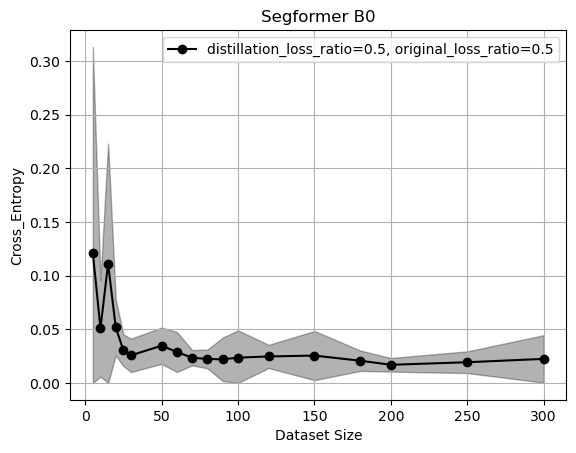

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()